In [ ]:
import pandas as pd
data = pd.read_csv("HIV.csv")
data

,smiles,activity,HIV_active
0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,CI,0
1,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,CI,0
2,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,CI,0
3,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,CI,0
4,O=S(=O)(O)CCS(=O)(=O)O,CI,0
...,...,...,...
41122,CCC1CCC2c3c([nH]c4ccc(C)cc34)C3C(=O)N(N(C)C)C(...,CI,0
41123,Cc1ccc2[nH]c3c(c2c1)C1CCC(C(C)(C)C)CC1C1C(=O)N...,CI,0
41124,Cc1ccc(N2C(=O)C3c4[nH]c5ccccc5c4C4CCC(C(C)(C)C...,CI,0
41125,Cc1cccc(N2C(=O)C3c4[nH]c5ccccc5c4C4CCC(C(C)(C)...,CI,0


In [ ]:
print(data.shape)
print(data["HIV_active"].value_counts())

(41127, 3)
HIV_active
0    39684
1     1443
Name: count, dtype: int64


In [ ]:
pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 21.9 MB/s eta 0:00:00


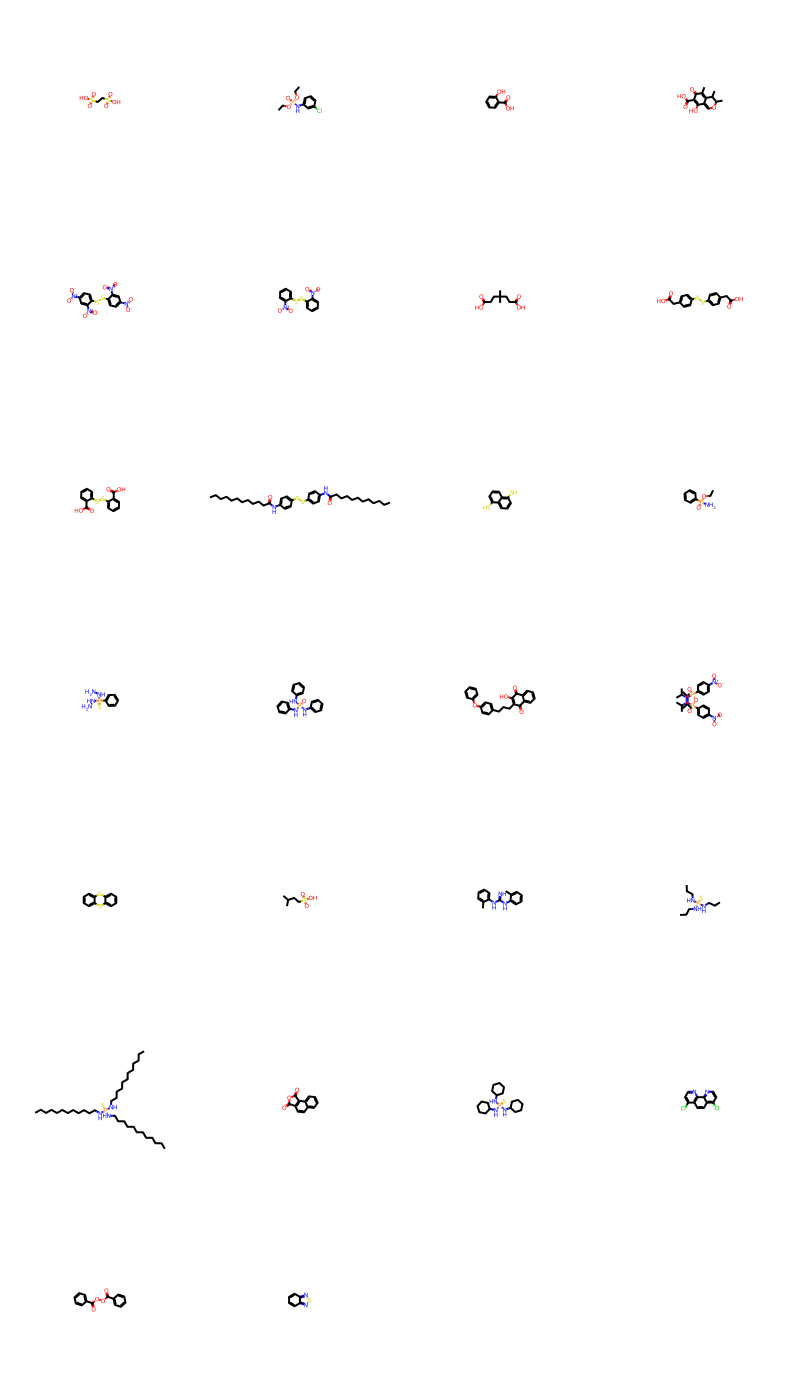

In [ ]:
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
sample_smiles = data["smiles"][4:30].values
sample_mols = [Chem.MolFromSmiles(smiles) for \
                smiles in sample_smiles]
grid = Draw.MolsToGridImage(sample_mols,
                            molsPerRow=4,
                            subImgSize=(200,200))
grid

In [ ]:
pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 4.2 MB/s eta 0:00:00


In [ ]:
import torch
import torch_geometric
from torch_geometric.data import Dataset , data
import numpy as np
import os
from rdkit.Chem import rdmolops
from tqdm import tqdm

class MoleculeDataset(Dataset):
  def __init__(self, root, transform = None, pre_transform=None):
    super(MoleculeDataset, self).__init__(root,transform,pre_transform)

  @property
  def raw_file_names(self):
    return[ 'HIV.csv']

  @property
  def processed_file_names(self):
    return ['data_0.pt']

  def raw_paths(self):
    return [os.path.join(self.root, f) for f in self.raw_file_names]

  def download(self):
    pass

  def process(self):
    self.data = pd.read_csv(self.raw_paths[0])
    for index, mol in tqdm(self.data.iterrows(), total = self.data.shape[0]):
      mol_obj = Chem.MolFromSmiles(mol["smiles"])
      #get node features
      node_feats = self._get_node_features(mol_obj)
      #get edge features
      edge_feats = self._get_edge_features(mol_obj)
      #get adjacency info
      edge_index = self._get_adjacency_info(mol_obj)
      #get lables info
      label = self._get_labels(mol["HIV_active"])


      #create data object
      data = Data(x=node_feats,
                  edge_index=edge_index,
                  edge_attr=edge_feats,
                  y=label,
                  smiles=mol["smiles"]
                  )
      torch.save(data,
                 os.path.join(self.processed_dir,
                              f'data_{index}.pt'))

  def _get_node_features(self, mol):
    all_node_feats = []

    for atom in mol.GetAtoms():
      node_feats = []
      #feature 1 : atomic no.
      node_feats.append(atom.GetAtomicNum())
      #feature 2: atom degree
      node_feats.append(atom.GetDegree())
      #feature 3 : formal charge
      node_feats.append(atom.GetFormalCharge())
      #feture 4 : hybridization
      node_feats.append(atom.GetHybridization())
      #feature 5 : aromaticity
      node_feats.append(int(atom.GetIsAromatic()))
      #append node features to matrix
      all_node_feats.append(node_feats)

    all_node_feats = np.asarray(all_node_feats)
    return torch.tensor(all_node_feats, dtype=torch.float)

  def _get_edge_features(self, mol):
    all_node_feats = []

    for bond in mol.GetBonds():
      edge_feats = []
      #feature 1: bond type
      edge_feats.append(bond.GetBondTypeAsDouble())
      #feature 2 : rings
      edge_feats.append(bond.IsInRing())
      #append node features to matrix
      all_edge_feats.append(edge_feats)

    all_edge_feats = np.asarray(all_edge_feats)
    return torch.tensor(all_edge_feats, dtype=torch.float)

  def _get_adjacency_info(self, mol):
    adj_matrix = rdmolops.GetAdjacencyMatrix(mol)
    row, col = np.where(adj_matrix)
    coo = np.array(list(zip(row, col)))
    coo = np.reshape(coo,(2,-1))
    return torch.tensor(coo, dtype=torch.long)

  def _get_labels(self, label):
    label = np.asarray([label])
    return torch.tensor(label, dtype=torch.int64)

  def len(self):
    return self.data.shape[0]

  def get(self, idx):
    data = torch.load(os.path.join(self.processed_dir,
                         f'data_{idx}.pt'))
    return data





In [ ]:
dataset = MoleculeDataset(root = '/content/')


TypeError: MoleculeDataset.__init__() missing 1 required positional argument: 'filename'

In [ ]:
print(dataset[0].edge_index.t())
print(dataset[0].x)
print(dataset[0].edge_attr)
print(dataset[0].y)

NameError: name 'dataset' is not defined